# Inference with Synthetic Data generated by the Markov model

In [1]:
import sys
import os

# remember the original sys.path
original_sys_path = sys.path.copy()

try:
    base_path = os.getcwd()

    # ../stefan/ is used to import src
    target_path = os.path.abspath(os.path.join(base_path, '../stefan/'))
    sys.path.insert(0, target_path)
    from src import Flag, AbstractTask, AbstractFlag, Pipeline

finally:
    # sys.path must be restored to original sys.path
    sys.path = original_sys_path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataPath = r"../stefan/data/csv/"
picklePath = r"../stefan/pickle_objects/modeling_pipeline/"
plotPath = r"../evaluation/confidence_level/markov/"
modelPath = r"../pickle_for_markov_model/"

In [3]:
# @author:
#    Stefan Richard Saxer

import pickle
with open(picklePath + 'Modeling Pipeline.pickle', 'rb') as f:
    ModelingPipeline = pickle.load(f)

ModelingPipeline.print(priority = True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [4]:
# @author:
#    Stefan Richard Saxer

with open(picklePath + 'Pre Processing.pickle', 'rb') as f:
    flag_preProcessing = pickle.load(f)

with open(picklePath +  'Modeling.pickle', 'rb') as f:
    flag_modeling = pickle.load(f)

with open(picklePath + 'Dummy Processing.pickle', 'rb') as f:
    flag_dummy= pickle.load(f)

with open(picklePath + 'Rate Modeling.pickle', 'rb') as f:
    flag_Rate_Modeling = pickle.load(f)

In [5]:
# @author:
#    Stefan Richard Saxer

def filesToDataFrame(filesDict: dict[str:AbstractFlag], filePath:str = dataPath, config:AbstractTask = ModelingPipeline) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict.keys():
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def Inference(dataset: pd.DataFrame, modelName: str, scalerName: str, path:str = modelPath):
    with open(path + modelName + ".pickle", 'rb') as f:
        model = pickle.load(f)

    with (open(path + scalerName + ".pickle", 'rb') as f):
        scaler = pickle.load(f)

    sourceData = dataset[['Source','Time']]
    dataset = dataset.drop(columns=['Source','Time'], axis = 1)

    X_scaled = scaler.transform(dataset.copy(deep=True).to_numpy())

    y_pred = model.predict_proba(X_scaled)
    y_pred = pd.DataFrame(data=y_pred, columns=model.classes_)

    y_pred = y_pred.round(4) * 100
    y_pred = pd.concat([sourceData, y_pred], axis=1)
    y_pred['Label'] = model.predict(X_scaled)
    y_pred['Label'] = y_pred['Label'].astype("string")

    y_pred['Max Proba'] = y_pred.iloc[:, 2:-1].max(axis = 1)

    return y_pred, list(model.classes_)

In [6]:
Modeling_Flag = Flag("Modeling", parents=[flag_modeling, flag_dummy, flag_preProcessing])

files = {"Inference/Bahnhof_V2.csv": Modeling_Flag,
         }

data = filesToDataFrame(files)

y_pred, labels = Inference(data, modelName = 'With synthetic data generated by the Markov model', scalerName='With synthetic data generated by the Markov scaler')

In [7]:
# @author:
#    Stefan Richard Saxer

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490031 entries, 0 to 490030
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Time                                        490031 non-null  datetime64[ns]
 1   Source                                      490031 non-null  string        
 2   Length Packet                               490031 non-null  int64         
 3   Length Header                               490031 non-null  int64         
 4   Length MS Data                              490031 non-null  int64         
 5   Length Service Data                         490031 non-null  int64         
 6   CH 37                                       490031 non-null  int64         
 7   CH 38                                       490031 non-null  int64         
 8   CH 39                                       490031 non-null  int64        

In [8]:
# @author:
#    Stefan Richard Saxer

y_pred.head()

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.297384024,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,99.99,0.00,iDevice FindMy online,99.99
1,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.298383951,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,99.99,0.00,iDevice FindMy online,99.99
2,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.299381971,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,99.99,0.00,iDevice FindMy online,99.99
3,7a:2d:7c:6b:c0:82,2024-04-25 15:42:32.300105095,0.00,0.01,0.00,0.00,8.27,0.01,0.05,0.00,0.02,91.63,other Device,91.63
4,de:c0:00:81:de:a0,2024-04-25 15:42:32.303154945,0.42,1.24,0.13,0.03,6.97,0.08,0.02,0.00,0.00,91.10,other Device,91.10


In [9]:
# @author:
#    Stefan Richard Saxer

def plotLorenz(dataToPlot):
    title_suffix = str(dataToPlot['Label'].iloc[0])
    title = 'Confidence: with Synthetic Data Generated by the Markov Model - ' + title_suffix

    dataToPlot = dataToPlot.sort_values(by = 'Max Proba', ascending = False)
    dataToPlot['Percentile'] = np.arange(0, dataToPlot.shape[0]) / (dataToPlot.shape[0] - 1)

    plt.figure(figsize = (16, 9), dpi = 100)
    plt.plot(dataToPlot['Percentile'], dataToPlot['Max Proba'] / 100)
    plt.xlim(0)
    plt.ylim(bottom = 0, top = 1.1)
    plt.title(title, fontsize = 20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Confidence", fontsize = 15)
    plt.xlabel("% of Packets", fontsize = 15)
    plt.tight_layout()
    plt.savefig(plotPath + title + '.png', dpi = 300)
    plt.show()

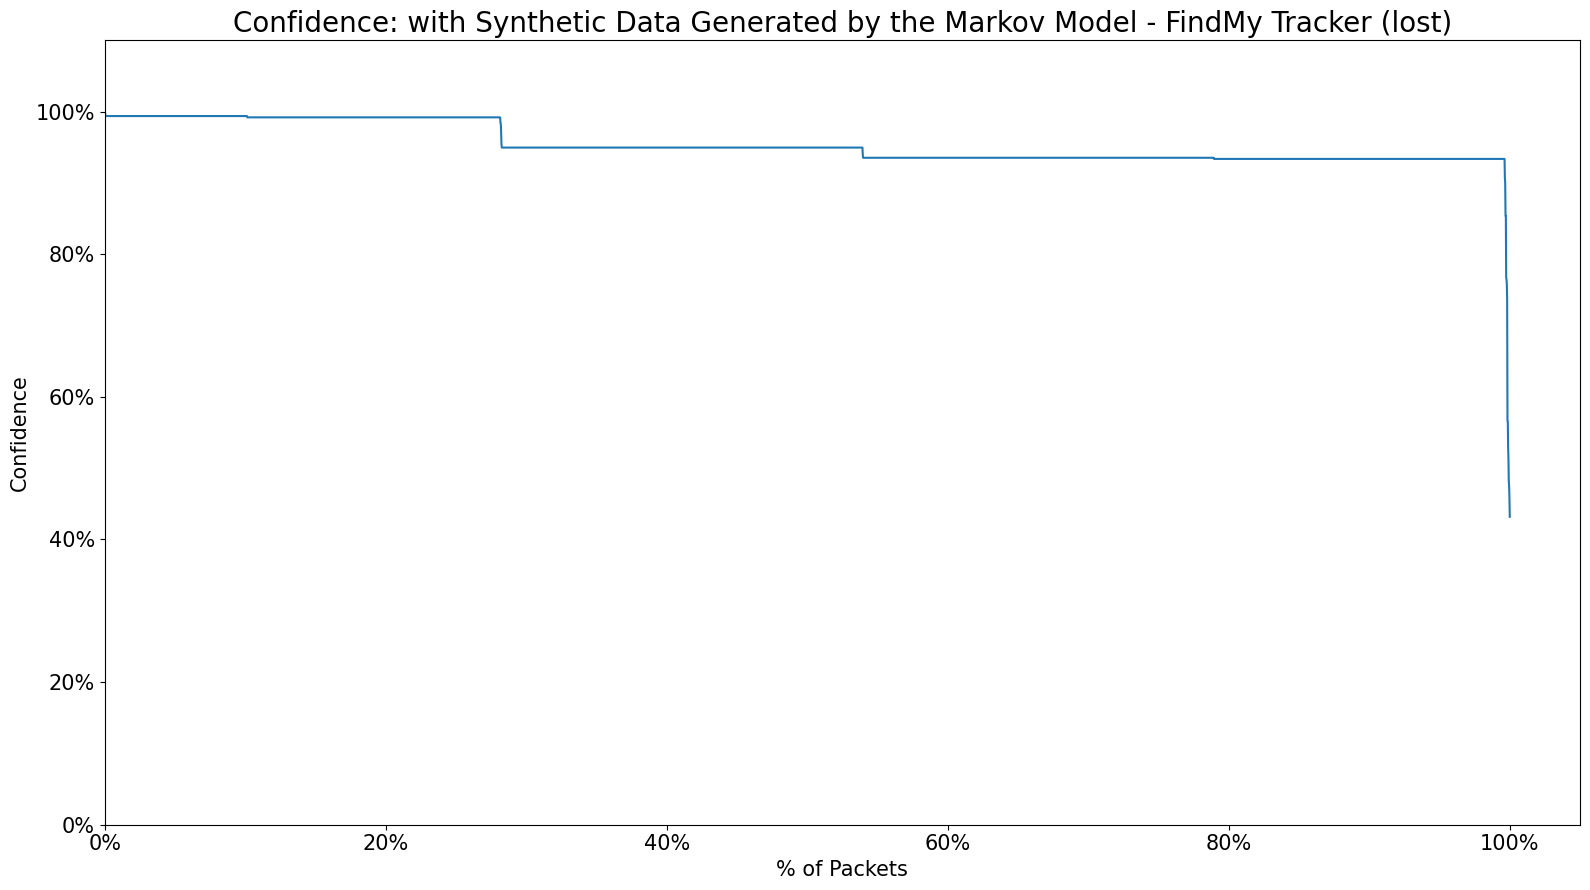

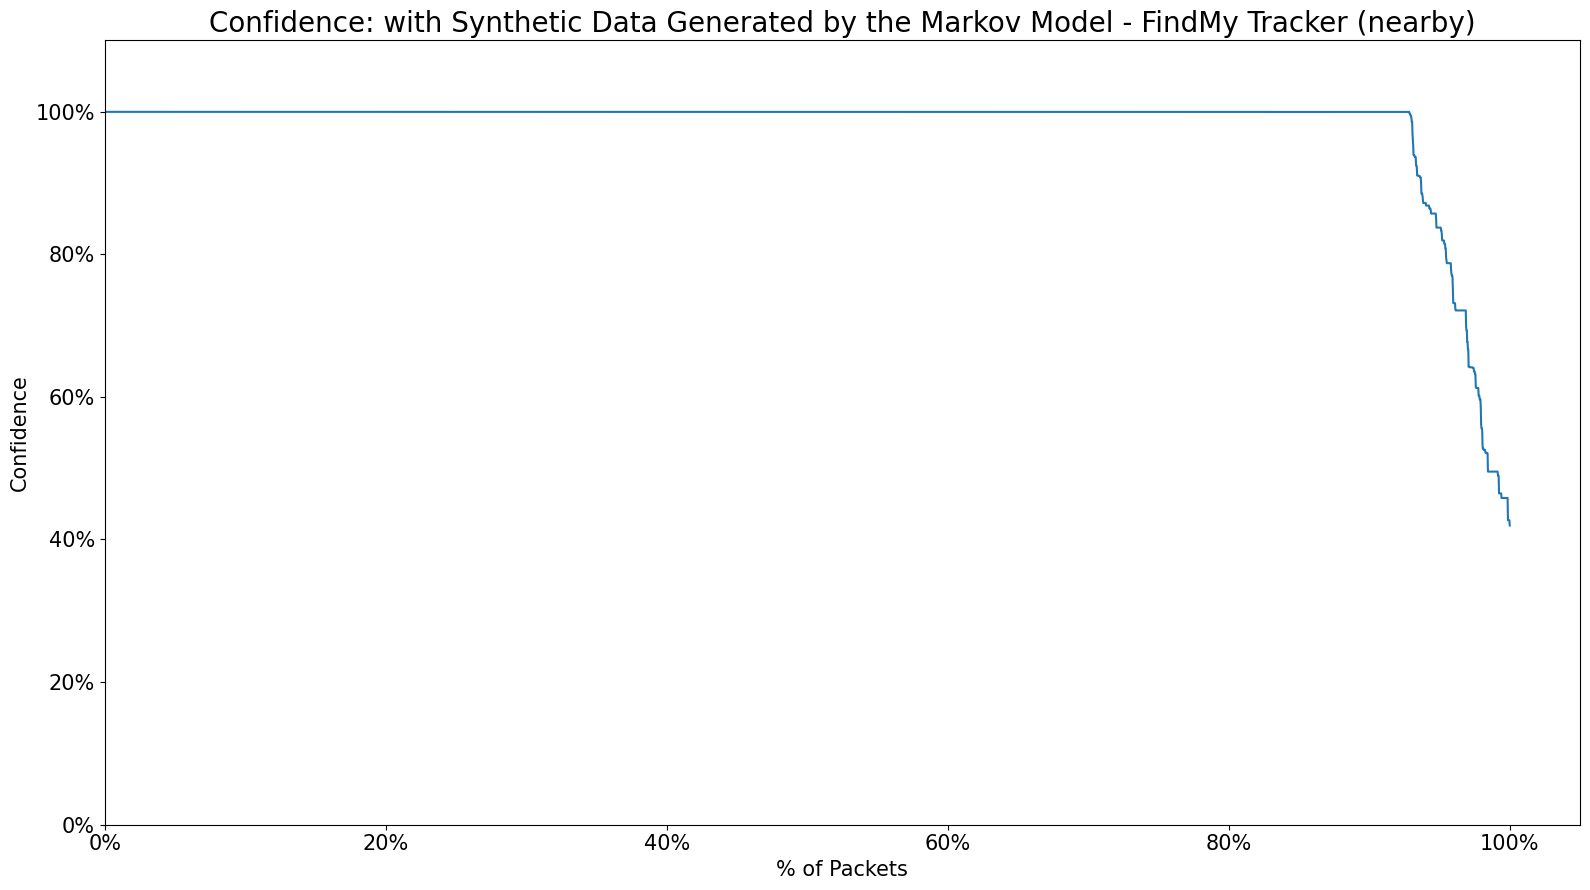

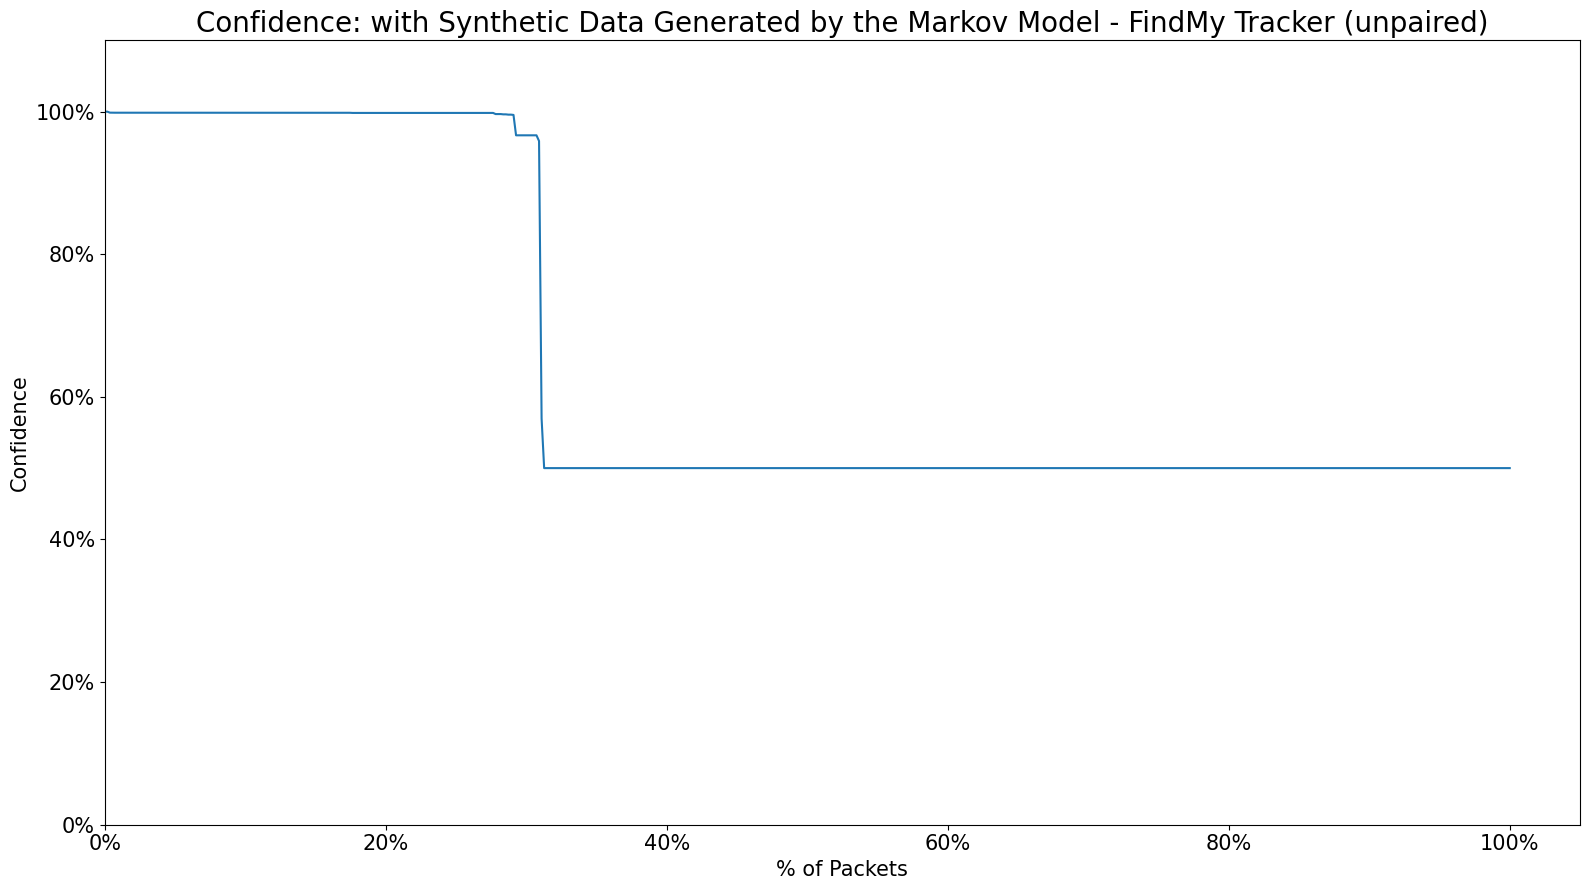

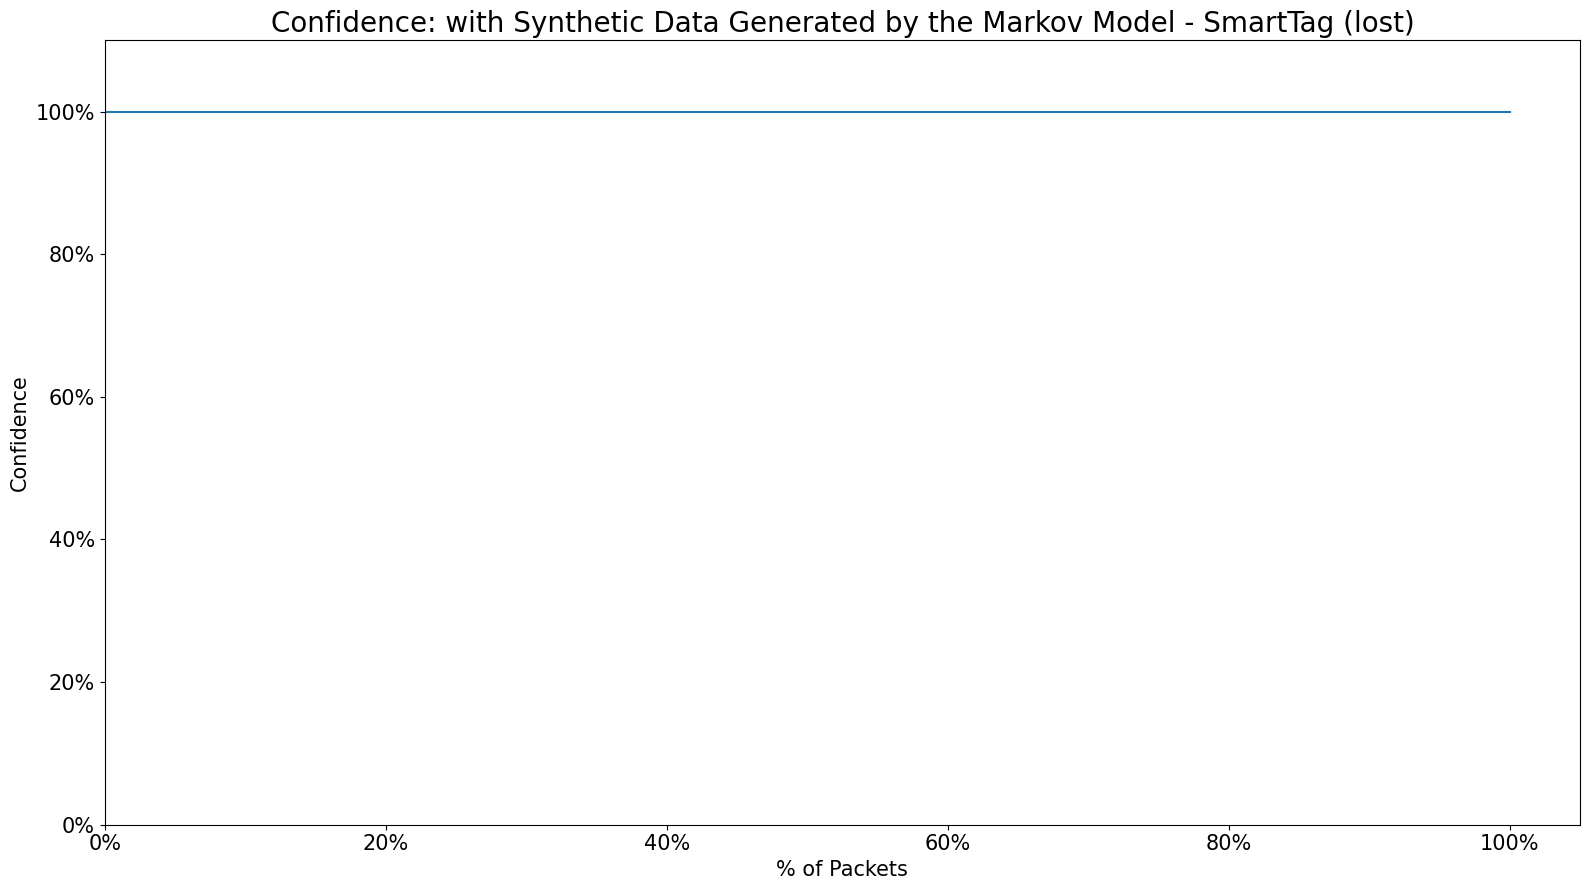

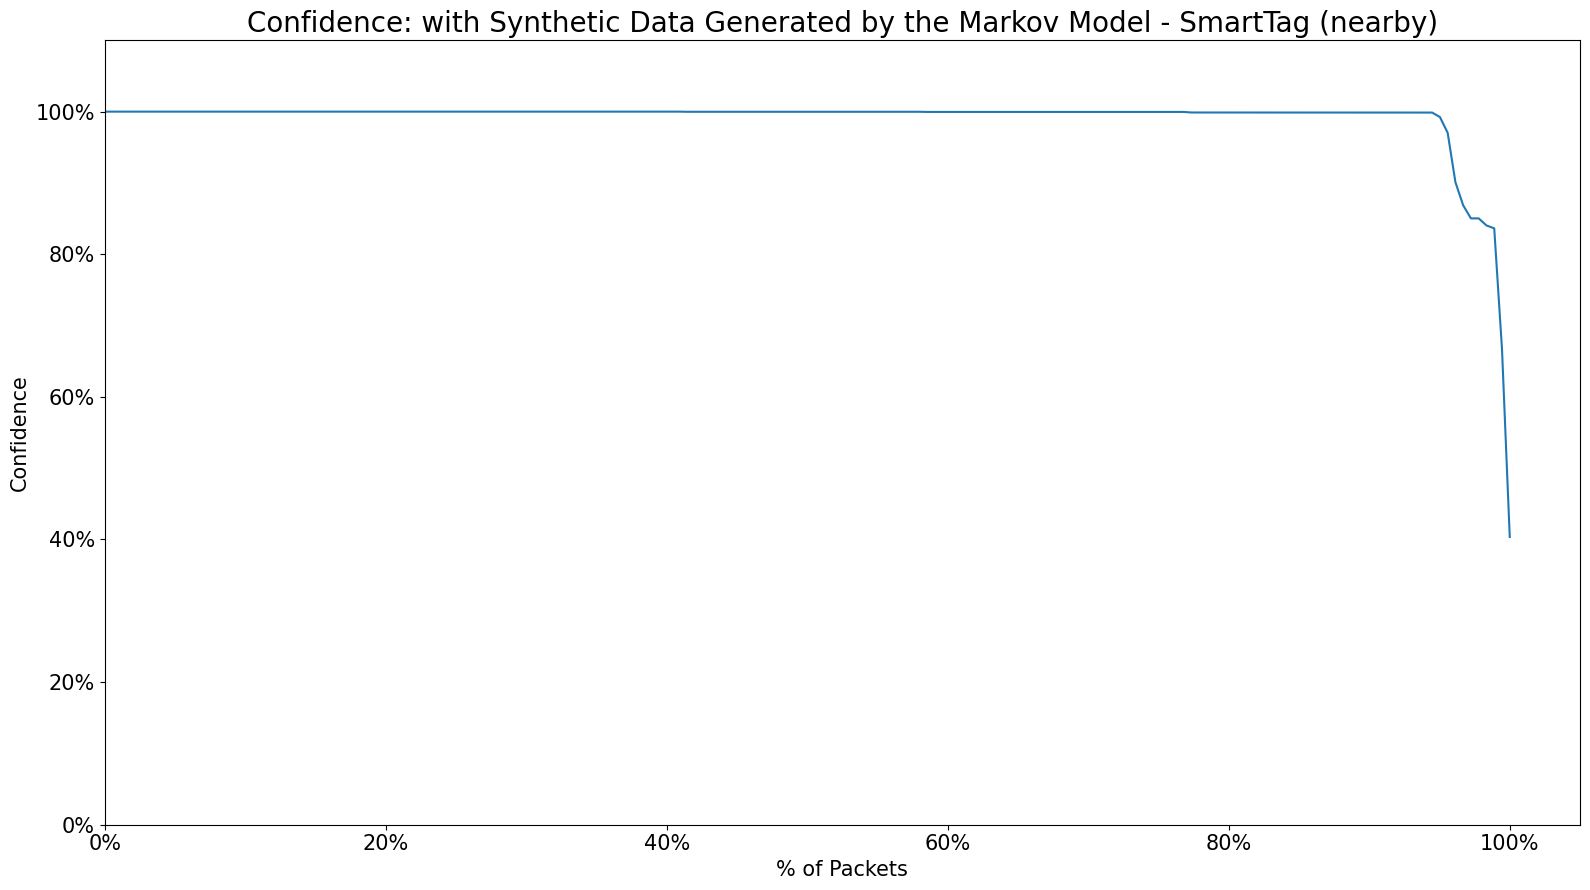

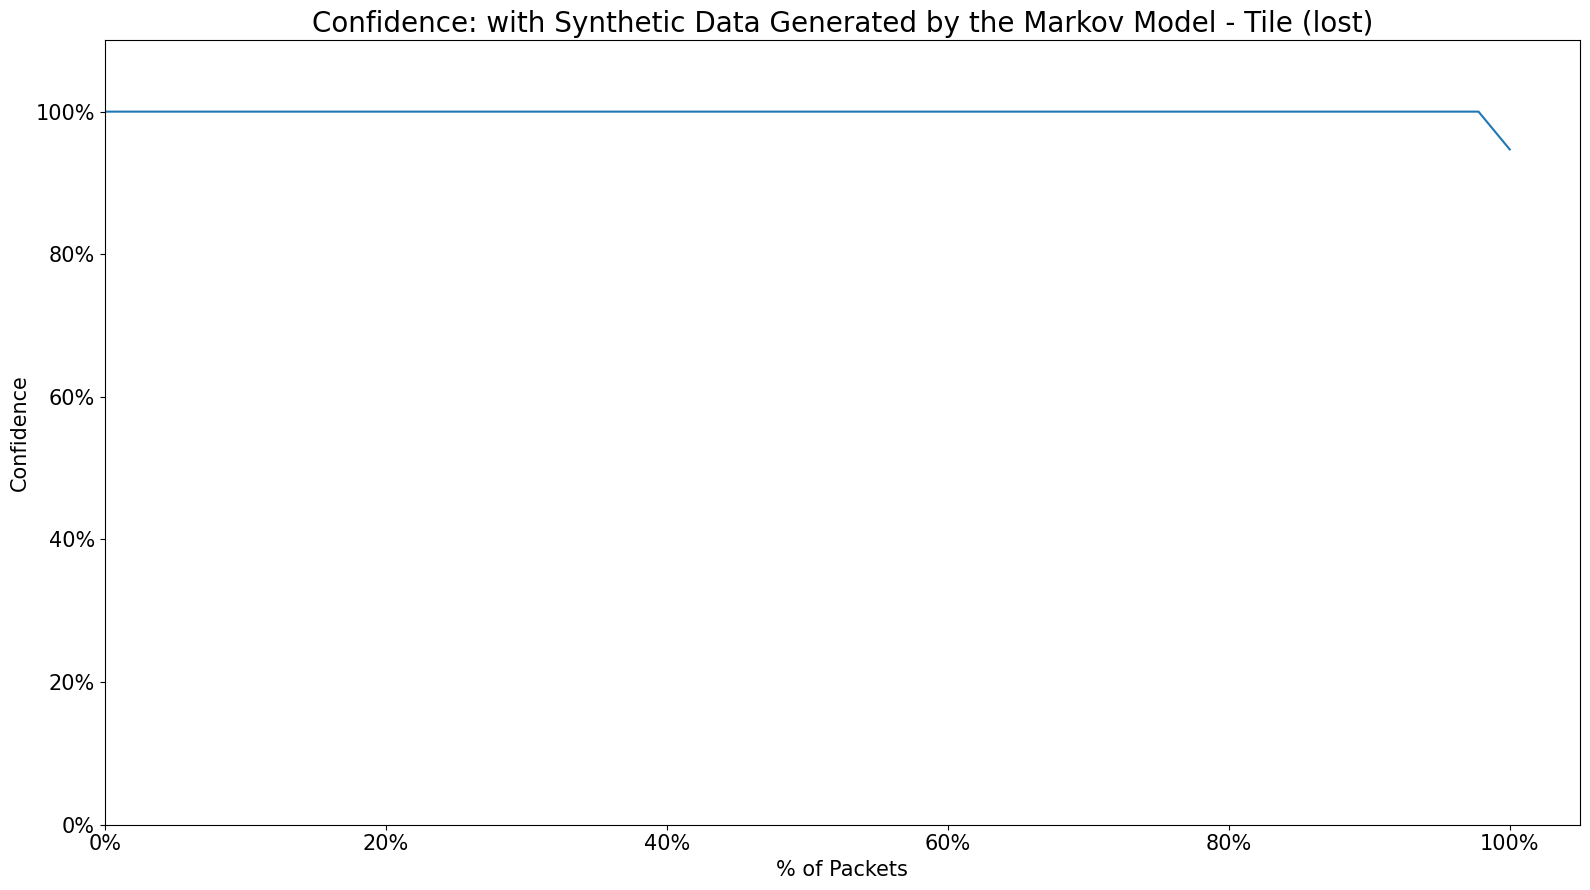

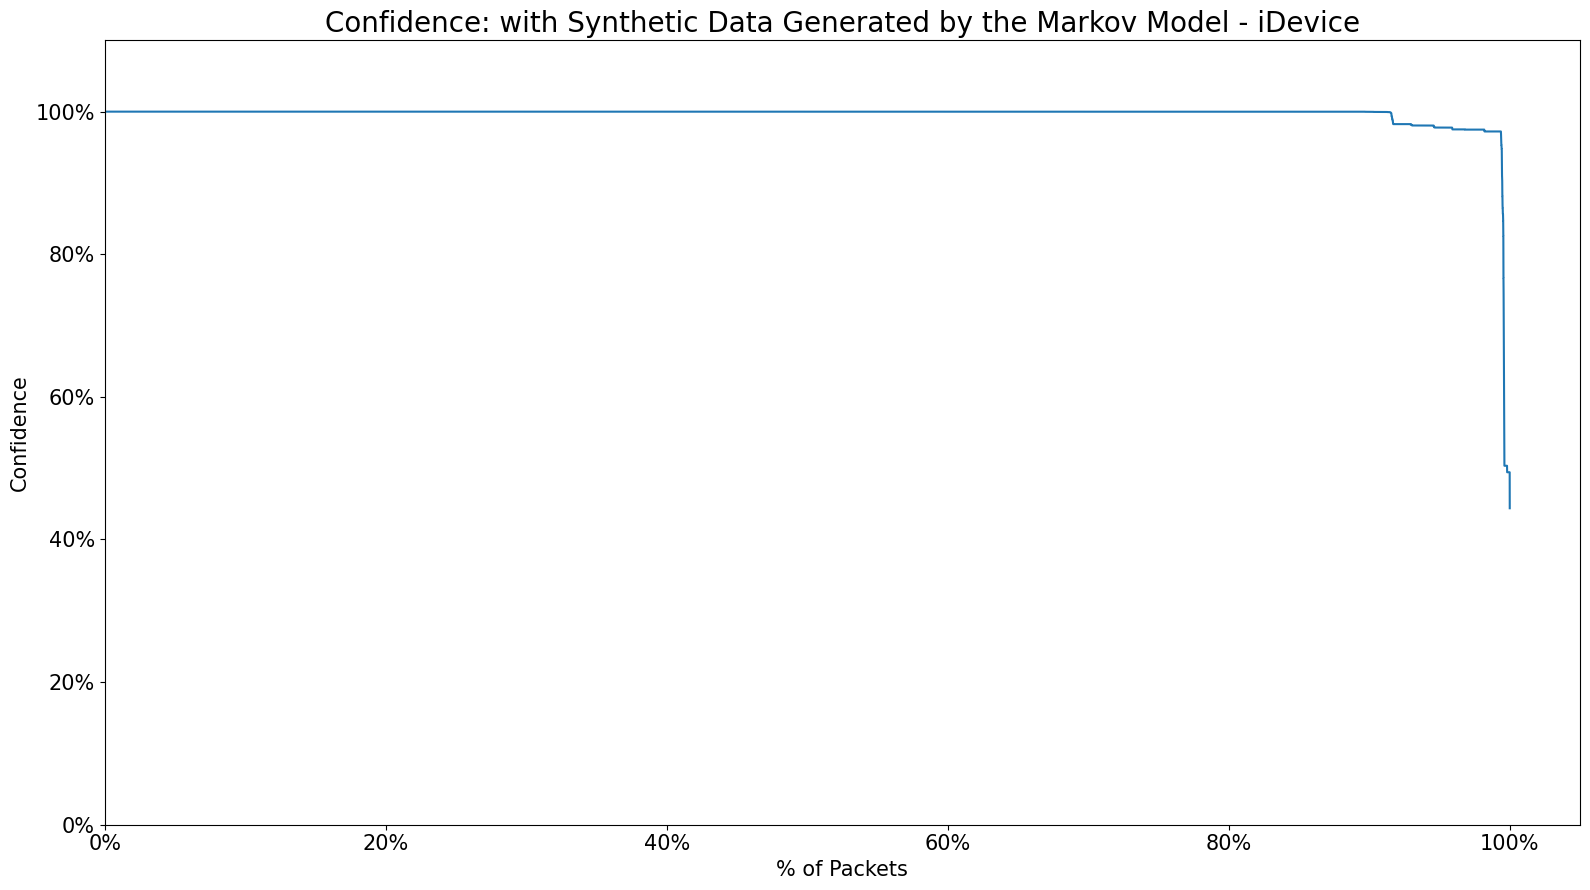

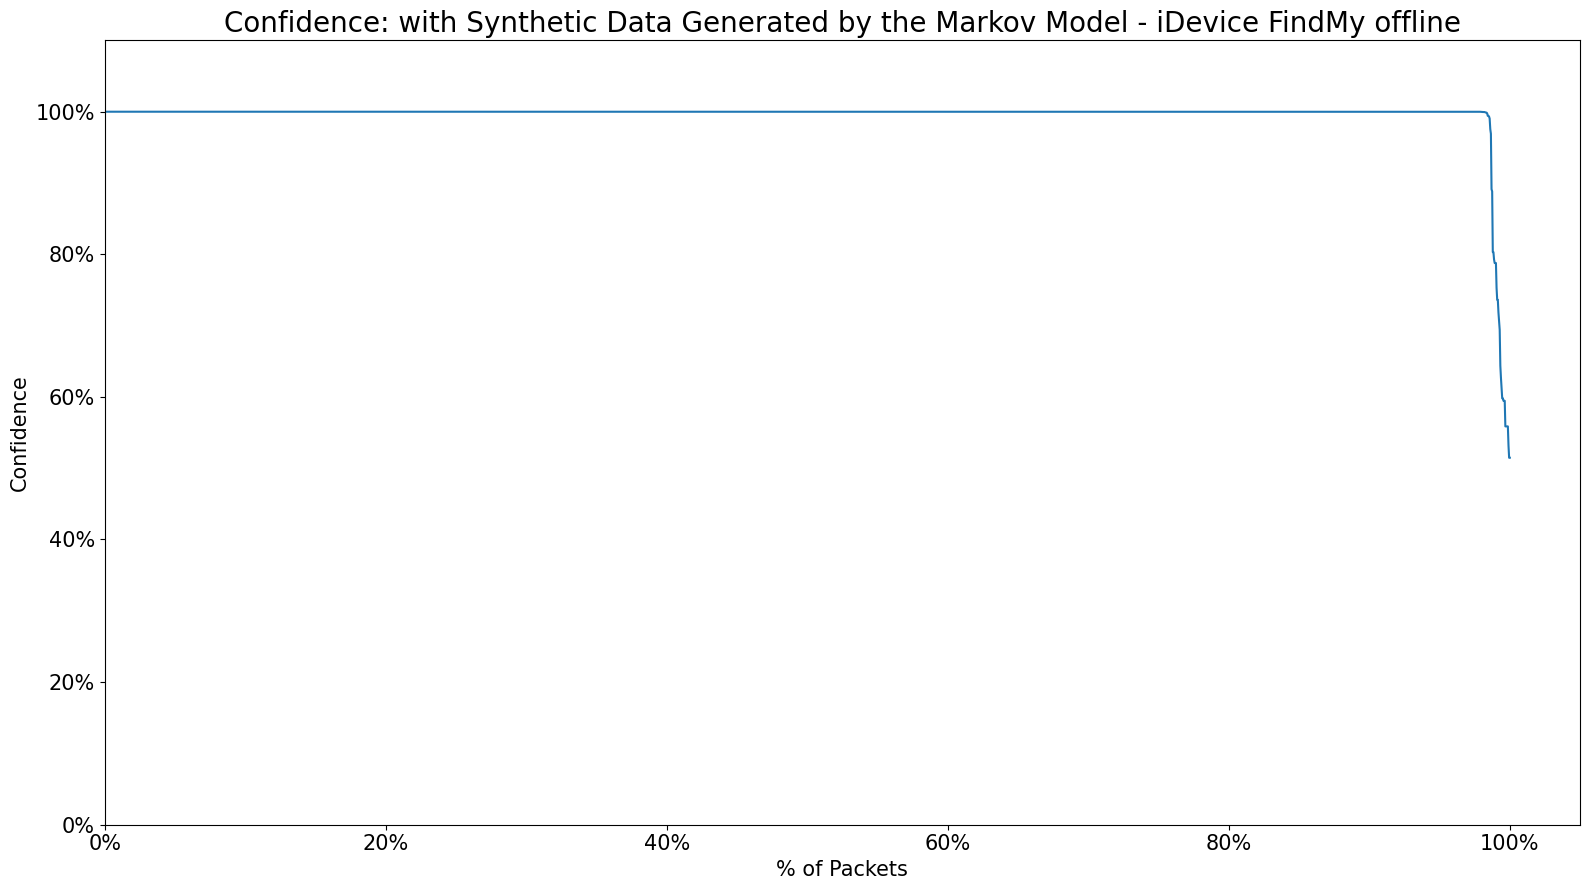

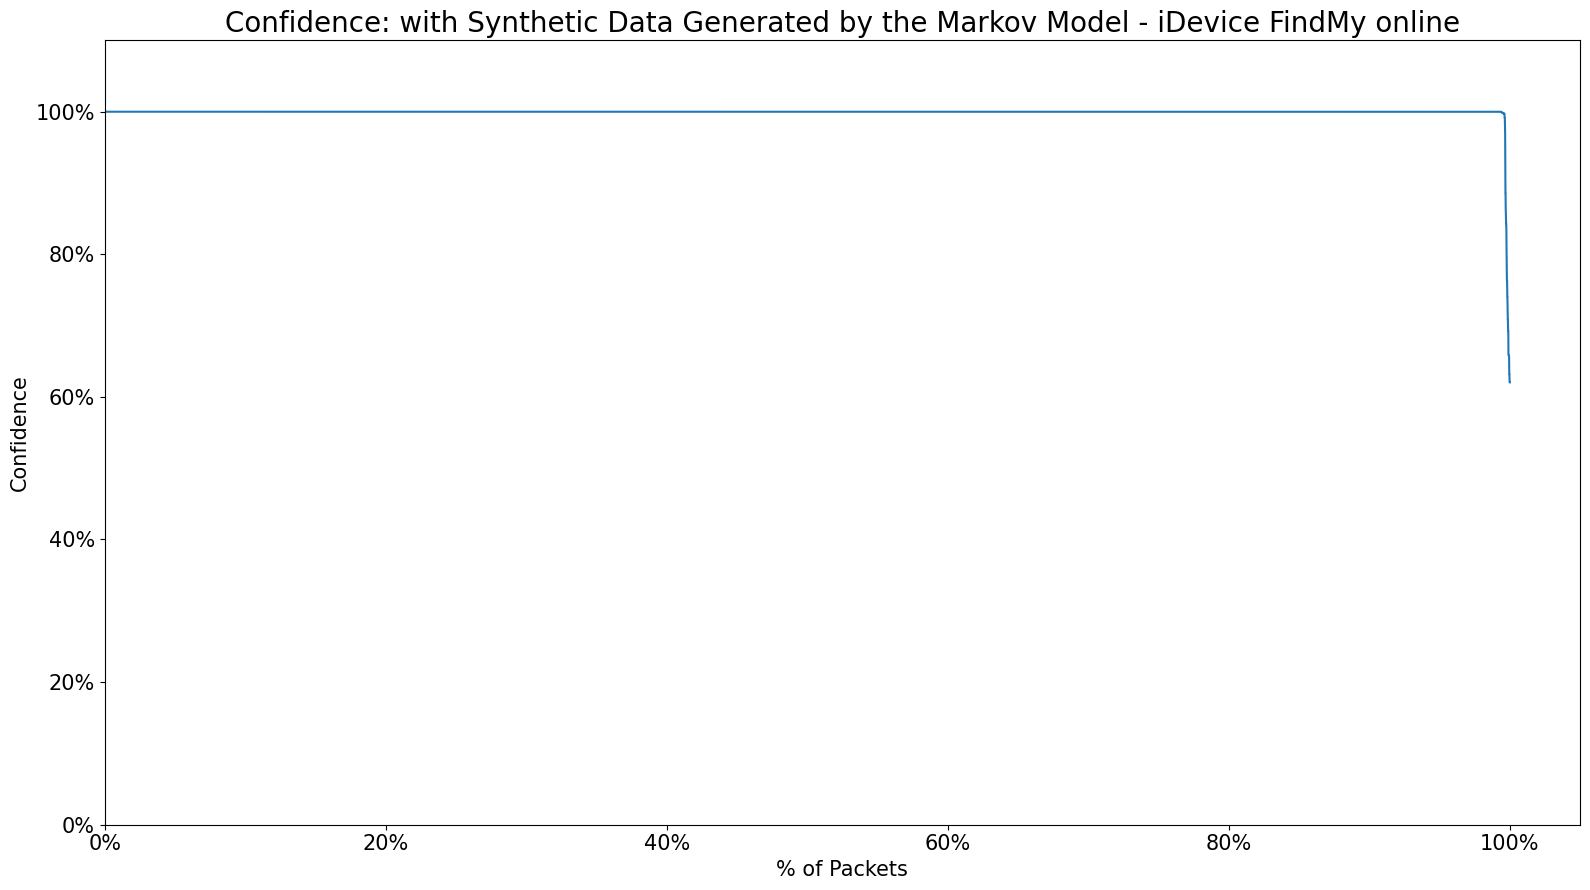

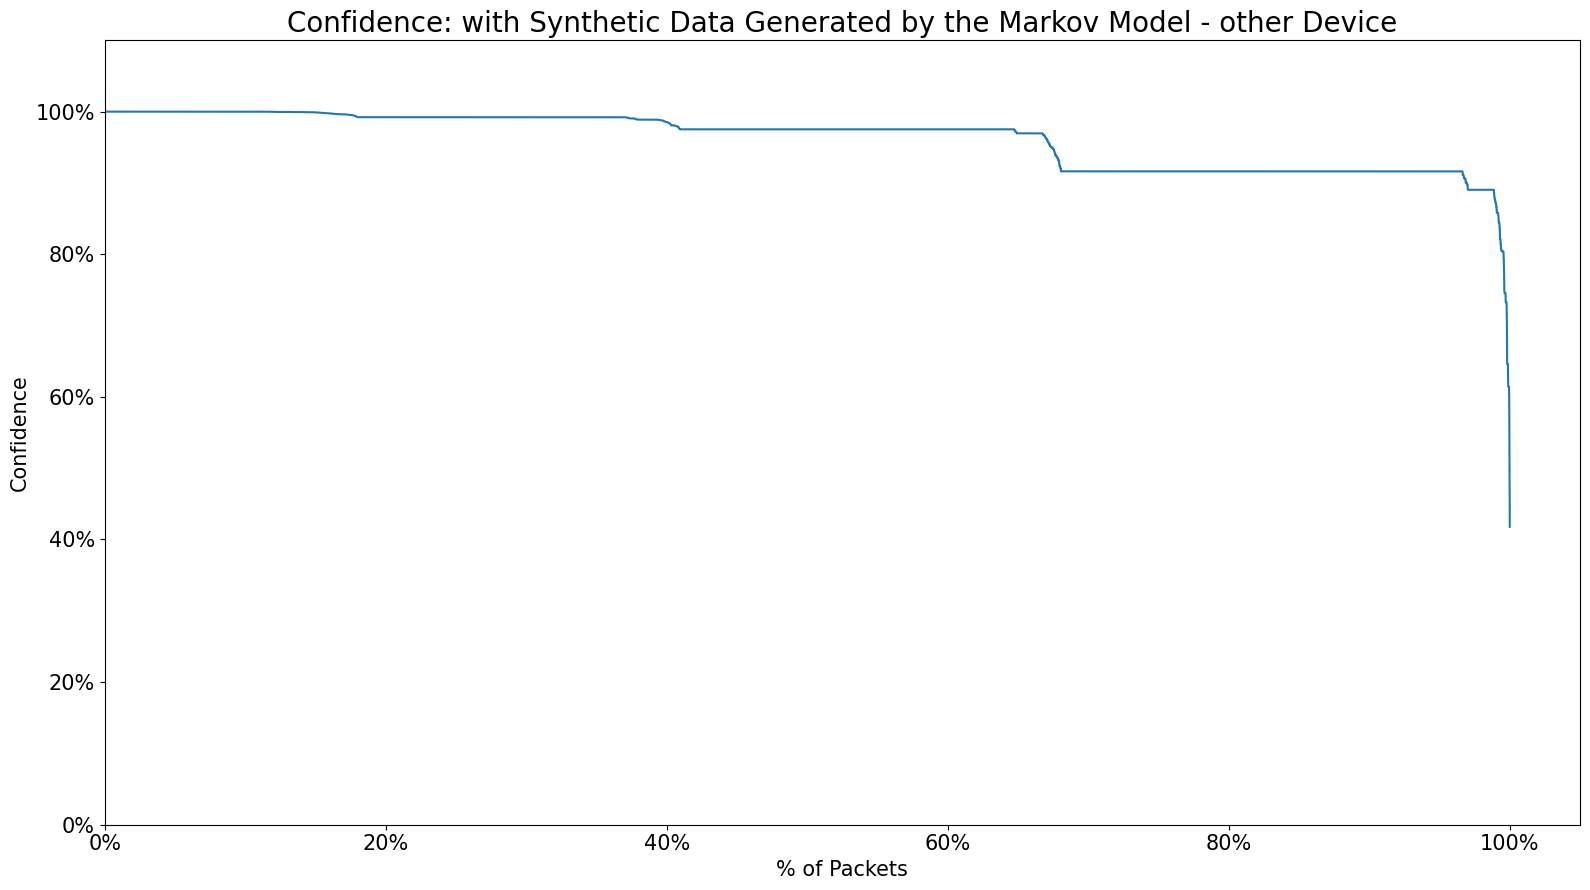

""


In [10]:
# @author:
#    Stefan Richard Saxer

y_pred.groupby('Label').apply(plotLorenz)